<a href="https://colab.research.google.com/github/indra622/AIAcademy_SpeechRecognition/blob/main/3_RNN_and_CTC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN & CTC

In [ ]:
import torch
import torchaudio
import torch.nn as nn
import IPython.display as ipd
import matplotlib.pyplot as plt

## CTC train data download


In [ ]:
!wget https://github.com/indra622/AIAcademy_SpeechRecognition/raw/main/set.wav

--2022-07-20 01:07:48--  https://github.com/indra622/AIAcademy_SpeechRecognition/raw/main/set.wav
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/set.wav [following]
--2022-07-20 01:07:48--  https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/set.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18998 (19K) [audio/wav]
Saving to: ‘set.wav’

set.wav             100%[===================>]  18.55K  --.-KB/s    in 0.001s  

2022-07-20 01:07:48 (32.7 MB/s) - ‘set.wav’ saved [18998/18998]



In [ ]:
!ls -hl

total 24K
drwxr-xr-x 1 root root 4.0K Jul 13 13:43 sample_data
-rw-r--r-- 1 root root  19K Jul 20 01:07 set.wav


### data check

In [ ]:
ipd.Audio("./set.wav")

In [ ]:
y,sr = torchaudio.load("./set.wav")

In [ ]:
y.shape,sr

(torch.Size([1, 9424]), 16000)

### audio feature extraction

In [ ]:
n_fft = 512
n_mels= 64
hop_length=n_fft//2
mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,n_mels=n_mels,hop_length=hop_length)
db_converter= torchaudio.transforms.AmplitudeToDB()

In [ ]:
mel_spec = mel_converter(y)
mel_spec = db_converter(mel_spec)

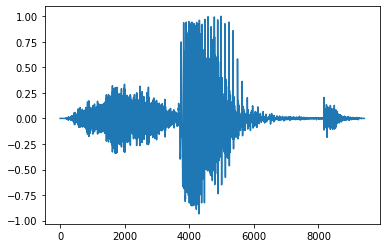

In [ ]:
plt.plot(y[0])

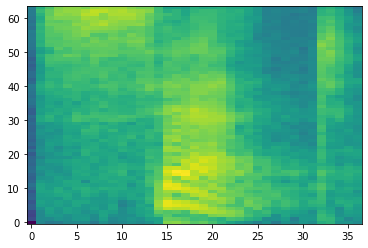

In [ ]:
plt.imshow(mel_spec[0],origin='lower',aspect='auto',interpolation='nearest')

### shape check
`mel_spec.shape ` : `(Batch, n_mels, Time step)`

In [ ]:
mel_spec.shape

torch.Size([1, 64, 37])

## Connectionist Temporal Classification
<img src="https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/img/CTC0.jpg" width=600>

### CTC 학습 준비


<img src="https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/img/CTC1.jpg" width=600>

<img src="https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/img/CTC2.jpg" width=600>

In [ ]:
import string
char_set = dict(zip(string.ascii_lowercase, range(1,27)))
char_list= [x for x in string.ascii_lowercase]
char_list.insert(0,'blk')  

In [ ]:
print(char_set)  #char2idx

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [ ]:
print(char_list) #idx2char

['blk', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### torch.nn.RNN

- input: tensor of shape $(L,H_{in})$ for unbatched input, $(L,N,H_{in}​)$ when `batch_first=False` or $(N,L,H_{in}​)$ when batch_first=True containing the features of the input sequence. The input can also be a packed variable length sequence. See `torch.nn.utils.rnn.pack_padded_sequence()` or `torch.nn.utils.rnn.pack_sequence()` for details.

$$
\begin{aligned}
N =& \text{batch size} \\
L =& \text{sequence length} \\
H_{in} =& \text{input_size} \\
\end{aligned}
$$

In [ ]:
mel_spec = mel_spec.transpose(1,2)

In [ ]:
mel_spec.shape

torch.Size([1, 37, 64])

In [ ]:
class RNNModel(nn.Module):
  def __init__(self,n_classes=27):
    super().__init__()  
    self.rnn = nn.RNN(64,64,2,batch_first=True)
    self.out_layer=nn.RNN(64,n_classes,1,batch_first=True)
    self.n_fft = 512
    self.n_mels= 64
    self.hop_length=n_fft//2
    self.mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,n_mels=n_mels,hop_length=hop_length)
    self.db_converter= torchaudio.transforms.AmplitudeToDB()

  def forward(self,x):
    x=self.mel_converter(x)
    x=self.db_converter(x)
    x=x.transpose(1,2)
    out,_ = self.rnn(x)
    out,_ = self.out_layer(out)
    out = torch.nn.functional.log_softmax(out,dim=-1)
    return out

  

In [ ]:
model = RNNModel()

In [ ]:
y,sr = torchaudio.load("set.wav")
out = model(y)

In [ ]:
out.shape

torch.Size([1, 37, 27])

In [ ]:
type(out[0])

torch.Tensor

In [ ]:
#plt.imshow(out[0])  <-error

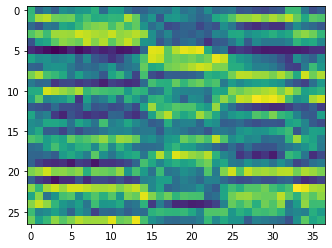

In [ ]:
plt.imshow(out[0].detach().numpy().T)

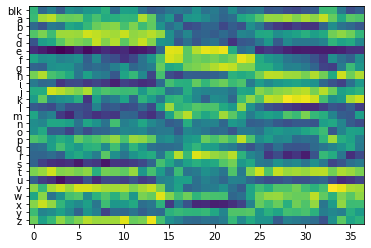

In [ ]:
plt.imshow(out[0].detach().numpy().T,aspect='auto')
ax = plt.gca()
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
plt.show()

tensor([[19,  5, 20]]) tensor([[3]])
torch.Size([1, 3]) torch.int64


  0%|          | 0/5000 [00:00<?, ?it/s]

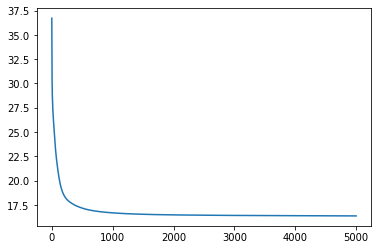

In [ ]:
from tqdm.auto import tqdm


T=97
C=27

num_epoch =5000
ctc_loss = nn.CTCLoss()

target = torch.tensor([[char_set['s'],char_set['e'],char_set['t']]],dtype=torch.int64)
target_lengths=torch.tensor([[3]])
print(target,target_lengths)
y,sr = torchaudio.load("set.wav")
batch = [[y,target]]
print(target.shape,target.dtype)
#print(model.rnn.all_weights)
model=RNNModel()
model.to('cuda')
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
#out = torch.randn((97,27))
losses = []
ctc_loss = nn.CTCLoss()
#input_lengths = torch.full(size=(1,), fill_value=37, dtype=torch.long)
input_lengths = torch.tensor(37 )
pbar = tqdm(range(num_epoch))
for e in  pbar:  
  for sample in batch:    
    x,y = sample
    x = x.to('cuda')
    y = y.to('cuda')
    pred = model(x)
    #print(input.shape)
    #pred = torch.argmax(input, dim=-1)
    #logit = torch.zeros_like(input).scatter_(1, pred.unsqueeze(1), 1.)    
    #input_lengths = torch.tensor([input.shape[1]])
    #print(pred.shape, target.shape, input_lengths, target_lengths)
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(losses)

In [ ]:
y,sr = torchaudio.load("set.wav")
model.to('cpu')
out = model(y)

In [ ]:
len(char_list)

27

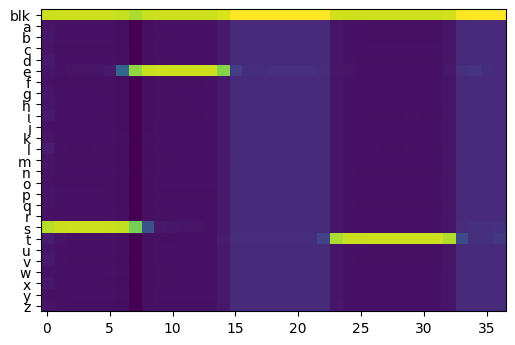

In [ ]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.imshow(out.detach().numpy()[0].T,aspect='auto')
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
plt.show()

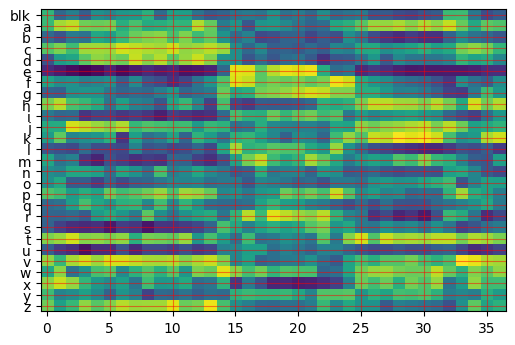

In [ ]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.imshow(out.detach().numpy()[0].T,aspect='auto')
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
plt.grid(alpha=0.5,color='r')
plt.show()

In [ ]:
def plot_ctc_result(out,epoch):
  fig, ax = plt.subplots(1,1,dpi=100)
  ax.set_title(f"{epoch} epoch result")
  ax.imshow(out.detach().numpy()[0].T,aspect='auto')
  ax.set_yticks(range(0,27))
  ax.set_yticklabels(char_list)
  plt.grid(alpha=0.5,color='r')
  plt.show()

tensor([[19,  5, 20]]) tensor([[3]])
torch.Size([1, 3]) torch.int64


  0%|          | 0/500 [00:00<?, ?it/s]

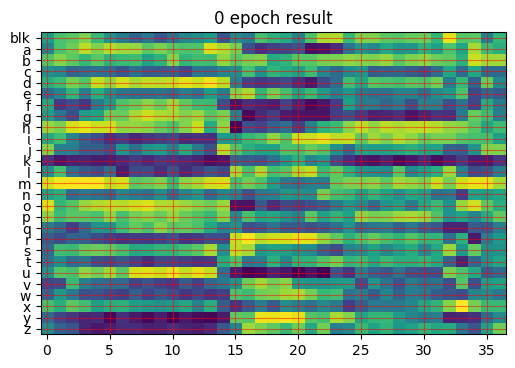

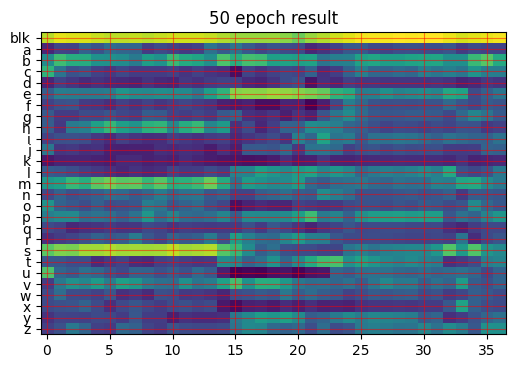

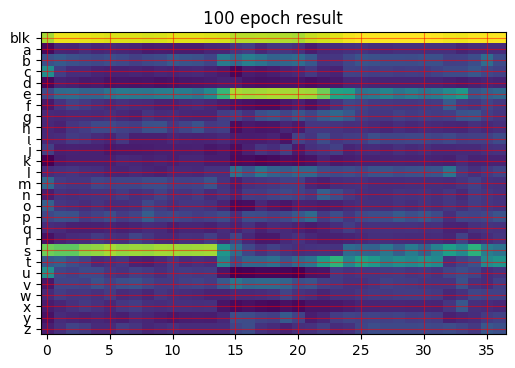

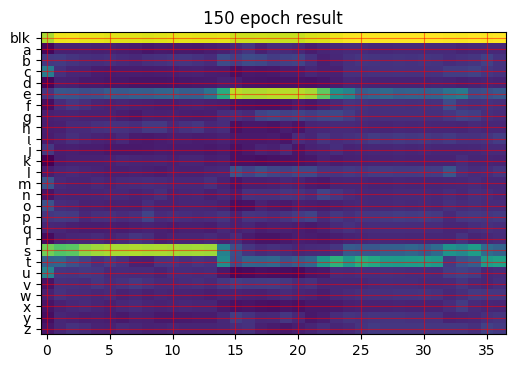

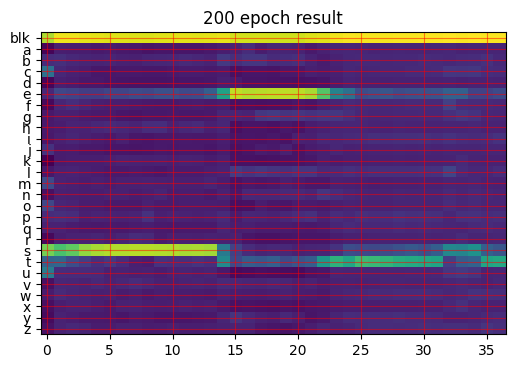

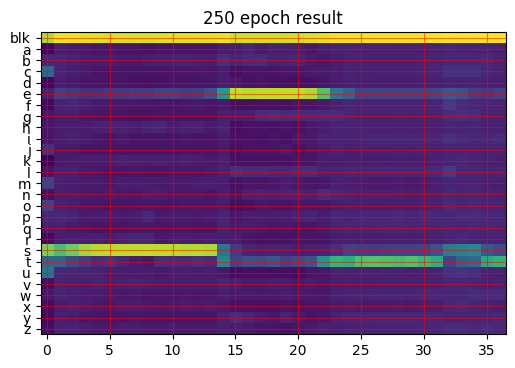

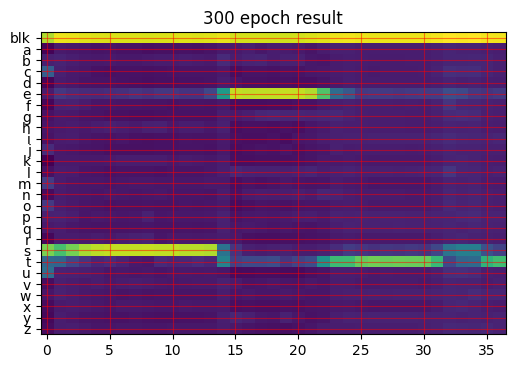

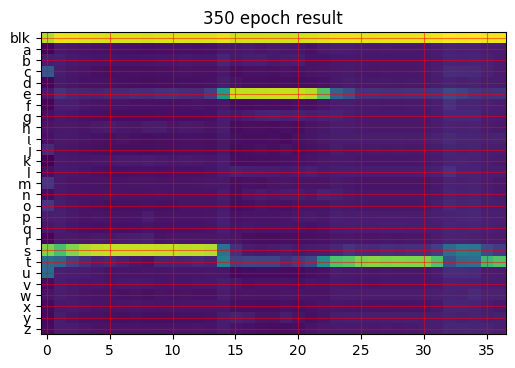

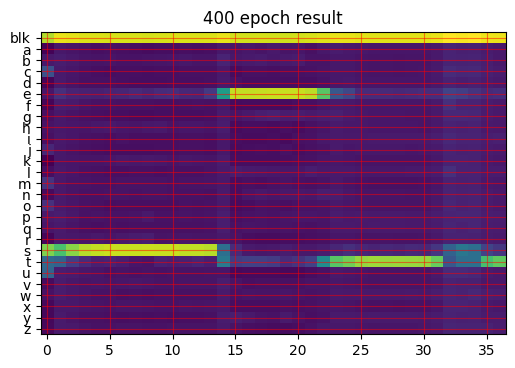

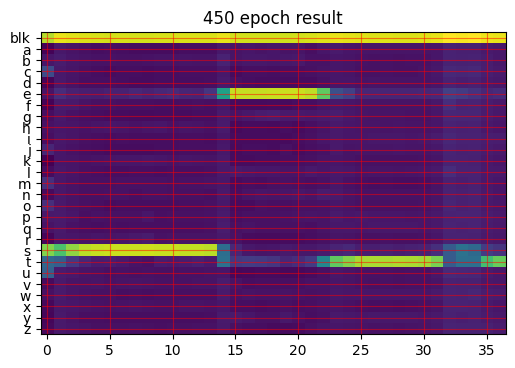

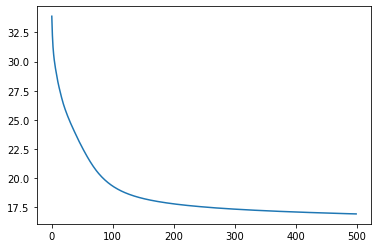

In [ ]:
from tqdm.auto import tqdm


T=97
C=27

num_epoch =500
ctc_loss = nn.CTCLoss()

target = torch.tensor([[char_set['s'],char_set['e'],char_set['t']]],dtype=torch.int64)
target_lengths=torch.tensor([[3]])
print(target,target_lengths)
y,sr = torchaudio.load("set.wav")
batch = [[y,target]]
print(target.shape,target.dtype)
#print(model.rnn.all_weights)
model=RNNModel()
model.to('cuda')
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
#out = torch.randn((97,27))
losses = []
ctc_loss = nn.CTCLoss()
#input_lengths = torch.full(size=(1,), fill_value=37, dtype=torch.long)
input_lengths = torch.tensor(37 )
pbar = tqdm(range(num_epoch))
for epoch in  pbar:  
  for sample in batch:    
    x,y = sample
    x = x.to('cuda')
    y = y.to('cuda')
    pred = model(x)
    #print(input.shape)
    #pred = torch.argmax(input, dim=-1)
    #logit = torch.zeros_like(input).scatter_(1, pred.unsqueeze(1), 1.)    
    #input_lengths = torch.tensor([input.shape[1]])
    #print(pred.shape, target.shape, input_lengths, target_lengths)
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0 :
      plot_ctc_result(pred.cpu(),epoch)
    
plt.plot(losses)

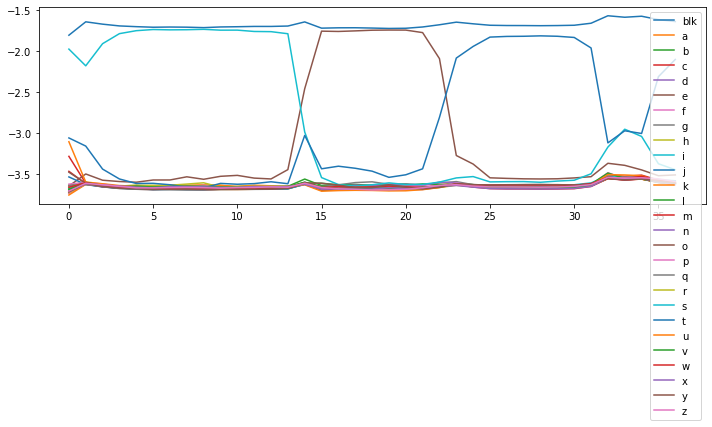

In [ ]:
data = pred[0].cpu().detach().numpy()
plt.figure(figsize=(10,5))
plt.plot(data)
plt.legend(char_list)
plt.tight_layout()

In [ ]:
import plotly.graph_objects as go
data = torch.exp(pred[0].cpu().detach()).numpy()
fig = go.Figure()
for idx,char_prob in enumerate(data.T):
  fig.add_trace(go.Line(y = char_prob,name=char_list[idx]))
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


